# Seasonality in Modeling (SARIMA)

## Imports

In [2]:
# imports

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

# set random seed
SEED = 321
np.random.seed(SEED)

sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize']=(12,3)

## Custom Functions

In [3]:
# plot forecast function
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [5]:
# regression metrics function
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [8]:
# Ad Fuller Test function
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [9]:
# acf pacf plot function
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

## Load Data

In [19]:
# Load data from statsmodels

In [18]:
import statsmodels.api as sm
co2_data = sm.datasets.co2.load_pandas()
df = co2_data.data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [23]:
# Impute null values
df['co2'] = df['co2'].interpolate()

# check for null values
df.isna().sum().sum()

0

### Resample Data to Monthly Using the Mean

In [26]:
# resample to monthly with "M" parameter
ts = df.resample("M").mean()

# preview data
ts.head()

,co2
1958-03-31,316.100
1958-04-30,317.200
1958-05-31,317.410
1958-06-30,316.675
1958-07-31,315.625


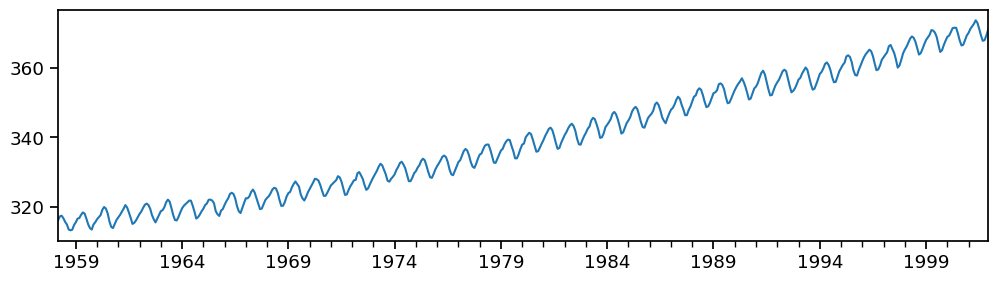

In [27]:
# define series
ts = ts['co2']

# plot series
ts.plot();

### Seasonal Decomposition

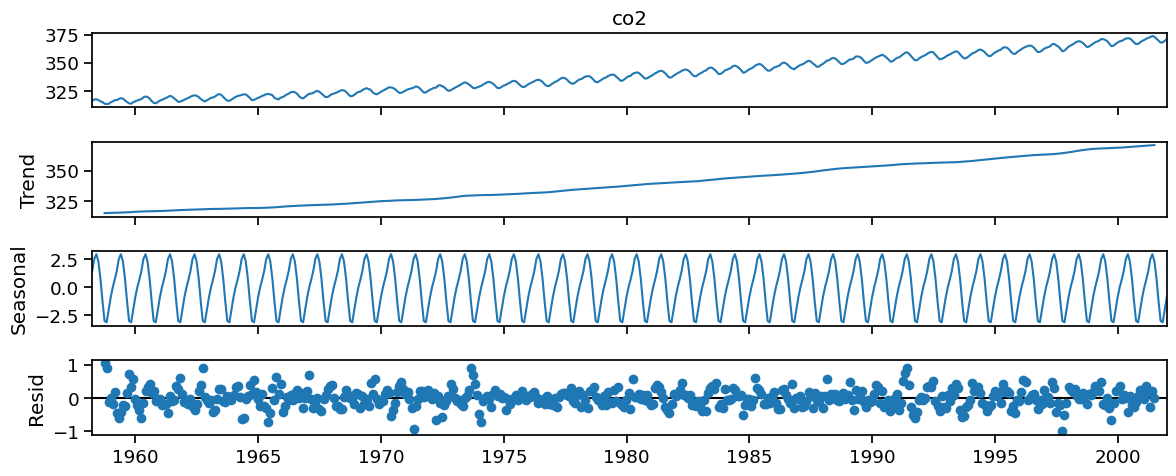

In [28]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

### Seasonal Component Size

In [29]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 6.0652410580715355 which is ~10.01% of the variation in time series.


### Seasonal Component Period

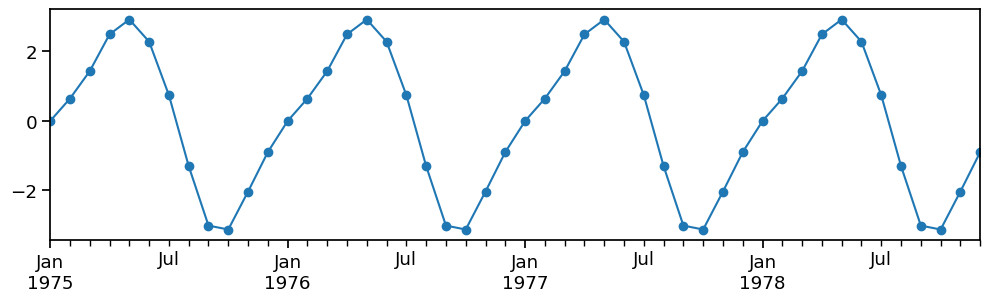

In [33]:
# Narrow down the date range of the plot in order to zoom in viz
seasonal = decomp.seasonal
ax = seasonal.loc['1975': '1978'].plot(marker = 'o')

# There are 12 points between peaks, indicating a seasonal period of 12 months.

# This makes sense with C02 data.

# We will need to use a seasonal model for this time series.

## Stationarity in SARIMA

### Seasonal Diffs

In [34]:
# determine d
d = ndiffs(ts)
print (f'd = {d}')

d = 1


In [36]:
# Determine D using nsdiffs with m as arg (12 here for 12 months)
D = nsdiffs(ts, m =12)
print(f'D = {D}')

D = 0


In [37]:
# seasonal diff not needed, regular diff needed once
ts_diff = ts.diff().dropna()

### Estimating Orders from ACF/PACF Plots

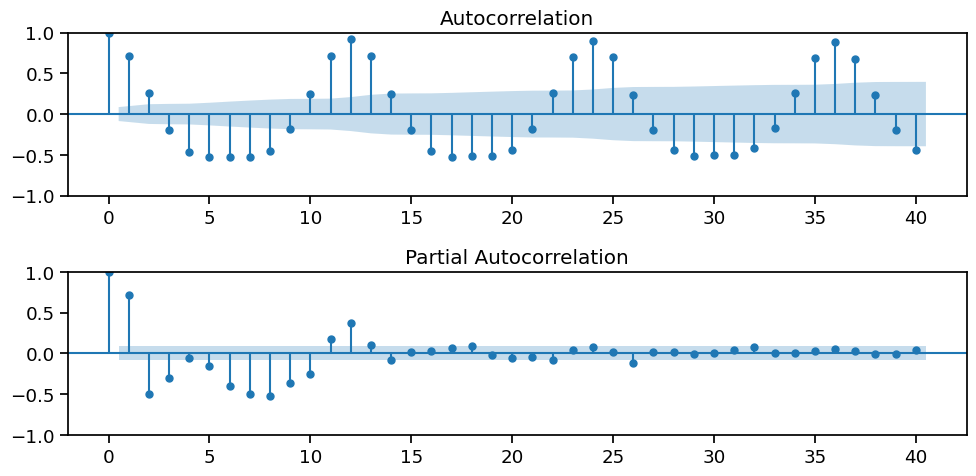

In [39]:
# use acf pacf plot custom function to highlight seasonal lags using m arg
plot_acf_pacf(ts_diff, m = 12);

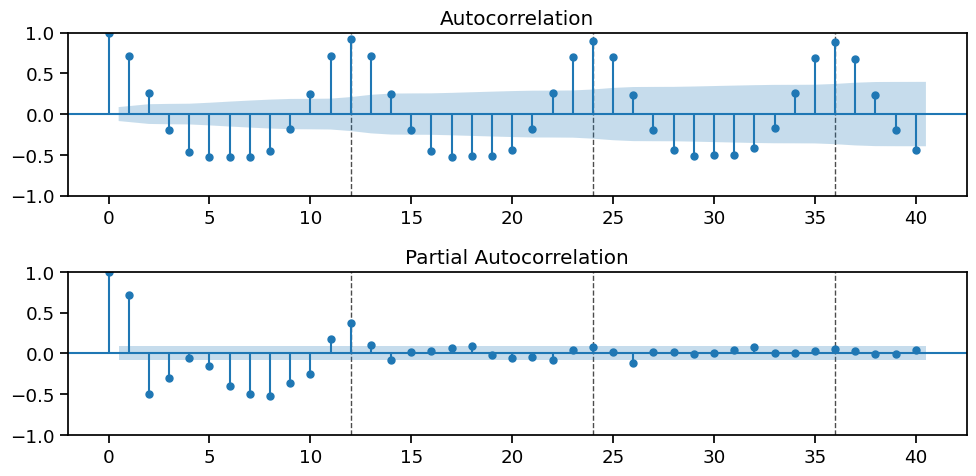

In [46]:
# add annotate_seas=True arg to show lines annotating seasons
plot_acf_pacf(ts_diff, m = 12, annotate_seas=True);
# = ARMA and SARMA because normal lags and seasonal lags are gradual

### Train Test Split

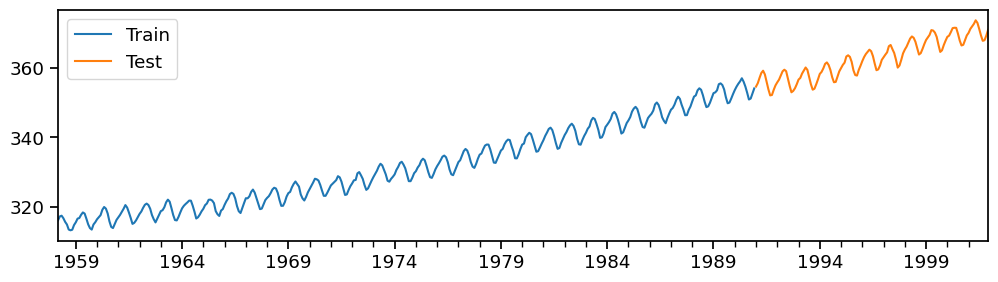

In [52]:
# t_t_s with test_size set to 25% of ts
train, test = train_test_split(ts, test_size = .25)

# plot train with label 'Train' as arg for legend to show
ax = train.plot(label='Train')

# plot test with label test
test.plot(ax=ax, label='Test')

# show legend
ax.legend();

### Fitting a SARIMA Model


In [ ]:
# same as ARIMA
# except must include seasonal orders as separate arg when defining seasonal model

In [56]:
 # orders for non-seasonal compnents (p,d,q)
p = 1 # AR
d = 1 # # of diffs
q = 1 # MA

In [57]:
# orders for seasonal components (P,D,Q,m)
P = 1 # SAR
D = 0 # # of diffs
Q = 1 # SMA
m = 12 # seasonal period

In [58]:
# fit SARIMA model
sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

### Evaluate SARIMA Model

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 0.795
- MSE = 0.951
- RMSE = 0.975
- R^2 = 0.969
- MAPE = 0.22%


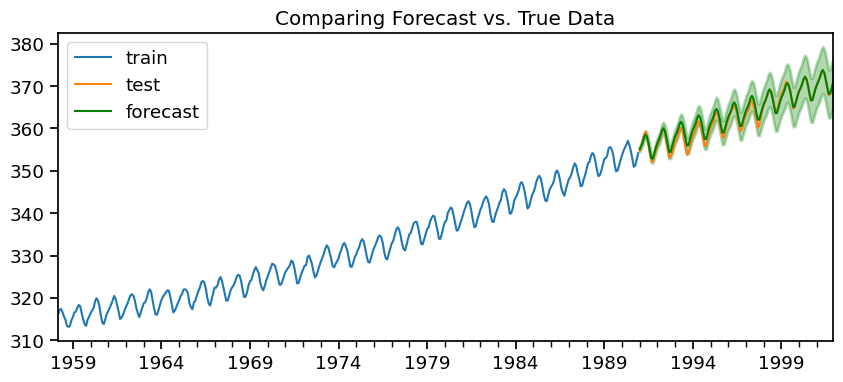

In [59]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])